In [1]:
import torch
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Setup experiment data

In [2]:
!tree experiments/imagenet1000/imagenet1000-pruned-wn/


experiments/imagenet1000/imagenet1000-pruned-wn/
├── ensemble_M3
│   ├── exp.config
│   ├── exp.result
│   ├── R0 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_R0/
│   ├── R1 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_R1/
│   ├── R2 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_R2/
│   └── result.log
├── ensemble_oe_M3
│   ├── exp.config
│   ├── exp.result
│   ├── R0 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet1000-pruned-wn/softpred_oe_R0/
│   ├── R1 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet1000-pruned-wn/softpred_oe_finetune_R0/
│   ├── R2 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet1000-pruned-wn/softpred_oe_finetune_R1/
│   └── result.log
├── ensemble_oe_M4
│   ├── exp.config
│   ├── exp.result
│   ├── R0 -> /home/rwl17/hierarchical-ood/experiments/imagenet1000/imagenet100

In [9]:
soft1kens = torch.load('experiments/imagenet1000/softmax/ensemble_M3/exp.result')

In [10]:
soft1kens

{'ood': {'MSP': {'TMP': {'TNR': 0.20689956331877735,
    'AUROC': 0.7957393755062047,
    'DTACC': 0.7299077362241517,
    'AUIN': 0.9304265253440483,
    'AUOUT': 0.4782601940313675}},
  'ODIN': {'TMP': {'TNR': 0.25100436681222704,
    'AUROC': 0.8098190837057302,
    'DTACC': 0.7449769765347561,
    'AUIN': 0.9320129179829043,
    'AUOUT': 0.5193923116430498}}},
 'acc': tensor(0.7705)}

In [51]:
# Dataset, Model, Loss, Hierarchy, Results Filenames
exp_info = [
    # Coarse softmax
    ['Coarse', 'Softmax', 'CE', None, ['experiments/coarse/softmax/R0/exp.result',
                                       'experiments/coarse/softmax/R1/exp.result',
                                       'experiments/coarse/softmax/R2/exp.result', ]],
#     ['Coarse', 'SoftmaxFC2', 'CE', None, ['experiments/coarse/softmaxfchead/LRp1_FC2_R0/exp.result',
#                                           'experiments/coarse/softmaxfchead/LRp1_FC2_R1/exp.result',
#                                           'experiments/coarse/softmaxfchead/LRp1_FC2_R2/exp.result',
#                                           ]],
    ['Coarse', 'SoftmaxFC3', 'CE', None, ['experiments/coarse/softmaxfchead/LRp1_R0/exp.result',
                                          'experiments/coarse/softmaxfchead/LRp1_R1/exp.result',
                                          'experiments/coarse/softmaxfchead/LRp1_R2/exp.result',
                                          ]],
#     ['Coarse', 'SoftmaxFC4', 'CE', None, ['experiments/coarse/softmaxfchead/LRp1_FC4_R0/exp.result',
#                                           'experiments/coarse/softmaxfchead/LRp1_FC4_R1/exp.result',
#                                           'experiments/coarse/softmaxfchead/LRp1_FC4_R2/exp.result',
#                                           ]],
    ['Coarse', 'SoftmaxFC5', 'CE', None, ['experiments/coarse/softmaxfchead/LRp1_FC5_R0/exp.result',
                                          'experiments/coarse/softmaxfchead/LRp1_FC5_R1/exp.result',
                                          'experiments/coarse/softmaxfchead/LRp1_FC5_R2/exp.result',
                                          ]],
    ['Coarse', 'Cascade', 'Soft1-1', 'NBDT', ['experiments/coarse/cascade/nbdt-binary/softpred_R0/exp.result',
                                              'experiments/coarse/cascade/nbdt-binary/softpred_R1/exp.result',
                                              'experiments/coarse/cascade/nbdt-binary/softpred_R2/exp.result',
                                             ]],
    ['Coarse', 'Cascade', 'Soft1-1', '2 Lvl WN', ['experiments/coarse/cascade/two-lvl-wn/softpred_R0/exp.result',
                                                  'experiments/coarse/cascade/two-lvl-wn/softpred_R1/exp.result',
                                                  'experiments/coarse/cascade/two-lvl-wn/softpred_R2/exp.result', ]],
    ['Coarse', 'Cascade', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascade/pruned-wn/softpred_R0/exp.result',
                                                   'experiments/coarse/cascade/pruned-wn/softpred_R1/exp.result',
                                                   'experiments/coarse/cascade/pruned-wn/softpred_R2/exp.result', ]],
    ['Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN', ['experiments/coarse/cascade/pruned-wn/softpred_oe_R0/exp.result',
                                                           'experiments/coarse/cascade/pruned-wn/softpred_oe_R1/exp.result',
                                                           'experiments/coarse/cascade/pruned-wn/softpred_oe_R2/exp.result',
                                                          ]],
    ['Coarse', 'CascadeDW', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascade/pruned-wn/softpred_R0_depthweight/exp.result',
                                                   'experiments/coarse/cascade/pruned-wn/softpred_R1_depthweight/exp.result',
                                                   'experiments/coarse/cascade/pruned-wn/softpred_R3_depthweight/exp.result', ]],
    ['Coarse', 'CascadeDW', 'Soft1-1,OE.2-.2', 'Pruned WN', ['experiments/coarse/cascade/pruned-wn/softpred_oe_R0_depthweight/exp.result',
                                                           'experiments/coarse/cascade/pruned-wn/softpred_oe_R1_depthweight/exp.result',
                                                           'experiments/coarse/cascade/pruned-wn/softpred_oe_R2_depthweight/exp.result',
                                                          ]],
    ['Coarse', 'CascadeDW', 'Soft1-1', '2 Lvl WN', ['experiments/coarse/cascade/two-lvl-wn/softpred_R0_depthweight/exp.result',
                                                    'experiments/coarse/cascade/two-lvl-wn/softpred_R1_depthweight/exp.result',
                                                    'experiments/coarse/cascade/two-lvl-wn/softpred_R2_depthweight/exp.result',]],
    ['Coarse', 'CascadeDW', 'Soft1-1', 'NBDT', ['experiments/coarse/cascade/nbdt-binary/softpred_R0_depthweight/exp.result',
                                                'experiments/coarse/cascade/nbdt-binary/softpred_R1_depthweight/exp.result',
                                                'experiments/coarse/cascade/nbdt-binary/softpred_R2_depthweight/exp.result',]],
#     ['Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC2_R0/exp.result',
#                                                       'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC2_R1/exp.result',
#                                                       'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC2_R2/exp.result', ]],
#     ['Coarse', 'CascadeFC2NS', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC2_nosplit_R0/exp.result',
#                                                         'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC2_nosplit_R1/exp.result',
#                                                         'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC2_nosplit_R2/exp.result', ]],
#     ['Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_R0/exp.result',
#                                                       'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_R1/exp.result',
#                                                       'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_R2/exp.result', ]],
    ['Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC3_R0/exp.result',
                                                        'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC3_R1/exp.result',
                                                        'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC3_R2/exp.result', ]],
    ['Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_oe_LRp1_FC3_R0/exp.result',
                                                              'experiments/coarse/cascadefchead/pruned-wn/softpred_oe_LRp1_FC3_R1/exp.result',
                                                              'experiments/coarse/cascadefchead/pruned-wn/softpred_oe_LRp1_FC3_R2/exp.result',
                                                               ]],
#     ['Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC4_R0/exp.result',
#                                                       'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC4_R1/exp.result',
#                                                       'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC4_R2/exp.result',
#                                                       ]],
    ['Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC5_R0/exp.result',
                                                      'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC5_R1/exp.result',
                                                      'experiments/coarse/cascadefchead/pruned-wn/softpred_LRp1_FC5_R2/exp.result',
                                                      ]],
#     ['Coarse', 'CascadeFC3', 'Soft1-5,OE1-1', 'Pruned WN', ['experiments/coarse/cascadefchead/pruned-wn/softpred_oe_LRp1_R0/exp.result',
#                                                             'experiments/coarse/cascadefchead/pruned-wn/softpred_oe_LRp1_R1/exp.result',
#                                                             'experiments/coarse/cascadefchead/pruned-wn/softpred_oe_LRp1_R2/exp.result',
#                                                             ]],
#     ['Coarse', 'MOS', 'MOS', '2 Lvl WN', ['experiments/coarse/mos/LRp1_R0/exp.result',
#                                           'experiments/coarse/mos/LRp1_R1/exp.result',
#                                           'experiments/coarse/mos/LRp1_R2/exp.result',
#                                           ]],
    ['Coarse', 'MOS', 'MOS', 'MOS Groups', ['experiments/coarse/mos/imagenet1000-mos_R0/exp.result',
                                            'experiments/coarse/mos/imagenet1000-mos_R1/exp.result',
                                            'experiments/coarse/mos/imagenet1000-mos_R2/exp.result',
                                            ]],
#     ['Coarse', 'MOSFC3', 'MOS', '2 Lvl WN', ['experiments/coarse/mos/FC3_LRp1_R0/exp.result',
#                                              'experiments/coarse/mos/FC3_LRp1_R1/exp.result',
#                                              'experiments/coarse/mos/FC3_LRp1_R2/exp.result',
#                                              ]],
    ['Coarse', 'MOSFC3', 'MOS', 'MOS Groups', ['experiments/coarse/mos/imagenet1000-mos_FC3_R0/exp.result',
                                               'experiments/coarse/mos/imagenet1000-mos_FC3_R1/exp.result',
                                               'experiments/coarse/mos/imagenet1000-mos_FC3_R2/exp.result',
                                               ]],
    # Imagenet1k
    ['Imagenet-1K', 'Softmax', 'CE', None, ['experiments/imagenet1000/softmax/lrp1_R0/exp.result',
                                            'experiments/imagenet1000/softmax/lrp1_R1/exp.result',
                                            'experiments/imagenet1000/softmax/lrp1_R2/exp.result', ]],
#     ['Imagenet-1K', 'SoftmaxFC5', 'CE', None,
#         ['experiments/imagenet1000/softmax/LRp1_FC5_R0/exp.result']],
    ['Imagenet-1K', 'MOS', 'MOS', 'MOS Groups', ['experiments/imagenet1000/mos/R0/exp.result',
                                                 'experiments/imagenet1000/mos/R1/exp.result',
                                                 'experiments/imagenet1000/mos/R2/exp.result',
                                                 ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN', ['experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_R0/exp.result',
                                                            'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_R1/exp.result',
                                                            'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_R2/exp.result',
                                                            ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN', [
        'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_oe_R0/exp.result',
        'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_oe_finetune_R0/exp.result',
    ]],
    ['Imagenet-1K', 'CascadeFC5', 'Soft1-1', 'Imagenet1K-WN', [
        'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_FC5_R0/exp.result',
    ]],
    ['Imagenet-1K', 'CascadeFC3', 'Soft1-1', 'Imagenet1K-WN', [
        'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_FC3_R0/exp.result',
        'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_FC3_R1/exp.result',
#         'experiments/imagenet1000/imagenet1000-pruned-wn/softpred_LRp1_FC3_R2/exp.result',
    ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN-100Synset', [
        'experiments/imagenet1000/imagenet1000-wn-100synset/softpred_LRp1_R0/exp.result',
    ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1,OE.2-.2', 'Imagenet1K-WN-100Synset', [
        'experiments/imagenet1000/imagenet1000-wn-100synset/softpred_oe_5to1_R0/exp.result',
    ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN-50Synset', [
        'experiments/imagenet1000/imagenet1000-wn-50synset/softpred_LRp1_R0/exp.result',
    ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1,OE.2-.2', 'Imagenet1K-WN-50Synset', [
        'experiments/imagenet1000/imagenet1000-wn-50synset/softpred_oe_5to1_R0/exp.result',
    ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1,OE.05-.05', 'Imagenet1K-WN-Custom', [
        'experiments/imagenet1000/imagenet1000-wn-custom/R0_oe_finetune/exp.result',
        'experiments/imagenet1000/imagenet1000-wn-custom/R1_oe_finetune/exp.result',
        'experiments/imagenet1000/imagenet1000-wn-custom/R2_oe_finetune/exp.result',
    ]],
    ['Imagenet-1K', 'Cascade', 'Soft1-1,OE.1-.1', 'Imagenet1K-MOS', [
        'experiments/imagenet1000/imagenet1000-mos/R0_oe_ft/exp.result',
        'experiments/imagenet1000/imagenet1000-mos/R1_oe_ft/exp.result',
        'experiments/imagenet1000/imagenet1000-mos/R2_oe_ft/exp.result',
    ]],
    # Balanced 100
    ['Balanced 100', 'Softmax', 'CE', None, ['experiments/balanced100/softmax/R0/exp.result',
                                             'experiments/balanced100/softmax/R1/exp.result',
                                             'experiments/balanced100/softmax/R2/exp.result',
                                            ]],
    ['Balanced 100', 'MOS', 'MOS', 'MOS Groups', ['experiments/balanced100/mos/R0/exp.result',
                                                  'experiments/balanced100/mos/R1/exp.result',
                                                  'experiments/balanced100/mos/R2/exp.result',
                                                 ]],
    ['Balanced 100', 'Cascade', 'Soft1-1', 'Pruned WN', ['experiments/balanced100/cascade/pruned-wn/R0_dw/exp.result',
                                                         'experiments/balanced100/cascade/pruned-wn/R1_dw/exp.result',
                                                         'experiments/balanced100/cascade/pruned-wn/R2_dw/exp.result',
                                                        ]],
    ['Balanced 100', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN', [
        'experiments/balanced100/cascade/pruned-wn/R0_oe/exp.result',
        'experiments/balanced100/cascade/pruned-wn/R1_oe/exp.result',
        'experiments/balanced100/cascade/pruned-wn/R2_oe/exp.result',
    ]],
]
model_idx = 1
res_idx = 4
loss_info = []
for einfo in exp_info:
    if 'softmax' in einfo[1].lower():
        loss_info.append([r"$\mathcal{L}_{CE}$", None])
    elif 'mos' in einfo[1].lower():
        loss_info.append([r"$\mathcal{L}_{MOS}$", None])
    else:
        lsplit = einfo[2].split(',')
        linfo = r""
        lranges = {'alpha': None,
                   'beta': None,
                   'gamma': None}
        for ns, s in enumerate(lsplit):
            rng = re.findall('\d+', s)
            if 'soft' in s.lower():
                linfo += r"$\mathcal{L}_\text{soft}$"
                lranges['alpha'] = f'{rng[0]}--{rng[1]}'
            elif 'oe' in s.lower():
                linfo += r"$\mathcal{L}_\text{out}$"
                lranges['gamma'] = f'{rng[0]}--{rng[1]}'
            elif 'syn' in s.lower():
                linfo += r"$\mathcal{L}_\text{syn}$"
                lranges['beta'] = f'{rng[0]}--{rng[1]}'
            else:
                print(s)
                raise ValueError("Unknown loss")
            if ns < len(lsplit)-1:
                linfo += ", "
        loss_info.append([linfo, lranges])

In [52]:
loss_info

[['$\\mathcal{L}_{CE}$', None],
 ['$\\mathcal{L}_{CE}$', None],
 ['$\\mathcal{L}_{CE}$', None],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$, $\\mathcal{L}_\\text{out}$',
  {'alpha': '1--1', 'beta': None, 'gamma': '2--2'}],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$, $\\mathcal{L}_\\text{out}$',
  {'alpha': '1--1', 'beta': None, 'gamma': '2--2'}],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$',
  {'alpha': '1--1', 'beta': None, 'gamma': None}],
 ['$\\mathcal{L}_\\text{soft}$, $\\mathcal{L}_\\text{out}$',
  {'alpha': '1--1', 'beta':

In [53]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 4)

In [54]:
exp_stats = []
ood_datasets = ['OOD','iNaturalist', 'SUN', 'Places', 'Textures', 'coarseid-coarseood', 'coarseid-fineood',
                'imagenet1000-coarseood', 'imagenet1000-mediumood', 'imagenet1000-fineood',
                'balanced100-coarseood', 'balanced100-mediumood', 'balanced100-fineood', 'balanced100-finemediumood',
               ]
ood_metrics = ['AUROC', 'TNR', 'AUOUT']
ood_labels = ['AUROC', 'FPR', 'AUPR']
for exp in exp_info:
    pred_acc = np.empty((len(exp[res_idx]))) * np.nan
    msp = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    odin = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    mos = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    pred_msp = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    pred_odin = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    entmean_msp = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    entmean_odin = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    entmin_msp = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    entmin_odin = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    entmax_msp = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    entmax_odin = np.empty((len(exp[res_idx]), len(ood_datasets), 3)) * np.nan
    res_list = [msp, odin,
                mos,
                pred_msp, pred_odin,
                entmean_msp, entmean_odin,
                entmin_msp, entmin_odin,
                entmax_msp, entmax_odin,
               ]
    res_desc = ['MSP', 'ODIN',
                'MOS',
                'Pred', 'Pred ODIN',
                'MeanEnt', 'Mean Entropy Temp Scaled',
                'MinEnt', 'Min Entropy Temp Scaled',
                'MaxEnt', 'Max Entropy Temp Scaled',
               ]
    for i, it in enumerate(exp[res_idx]):
        it_res = torch.load(it)
        # Check if metrics include other ood sets
        try:
            if isinstance(it_res['ood'], tuple):
#                 print('tuple')
                it_res['ood'] = it_res['ood'][0]
                if 'MOS' in it_res['ood'].keys():
#                     print('MOS')
                    if 'OOD' not in it_res['ood']['MOS'].keys(): 
#                         print('NO OOD DATASETS')
                        it_res['ood']['MOS'] = {'OOD': it_res['ood']['MOS']}
                elif 'OOD' not in it_res['ood']['MSP'].keys():
#                     print('NO OOD DATASETS')
                    it_res['ood']['MSP'] = {'OOD': it_res['ood']['MSP']}
                    it_res['ood']['ODIN'] = {'OOD': it_res['ood']['ODIN']}
            elif 'MOS' in it_res['ood'].keys():
#                 print('NO OOD TUPLE')
#                 print('MOS')
                if 'OOD' not in it_res['ood']['MOS'].keys(): 
#                     print('NO OOD DATASETS')
                    it_res['ood']['MOS'] = {'OOD': it_res['ood']['MOS']}
            elif 'OOD' not in it_res['ood']['MSP'].keys():
#                 print('NO OOD TUPLE')
#                 print('NO OOD DATASETS')
                it_res['ood']['MSP'] = {'OOD': it_res['ood']['MSP']}
                it_res['ood']['ODIN'] = {'OOD': it_res['ood']['ODIN']}
        except:
            import pdb; pdb.set_trace()
        if it_res['pred'] is None:
            pred_acc[i] = float(it_res['top1']) 
        elif isinstance(it_res['pred'],np.ndarray):
            if it_res['pred'].size > 1:
                pred_acc[i] = float(it_res['pred'][0])
            else:
                pred_acc[i] = float(it_res['pred'])
        elif len(it_res['pred'].size()) > 0:
            pred_acc[i] = float(it_res['pred'][0])
        else:
            pred_acc[i] = float(it_res['pred'])
        for didx, dname in enumerate(ood_datasets):
            if 'MOS' in it_res['ood'].keys():
                if dname not in it_res['ood']['MOS'].keys():
                    continue
            else:
                if dname not in it_res['ood']['MSP'].keys():
                    continue
            for ood_res, ood_method in zip(res_list, res_desc):
                for mi, met in enumerate(ood_metrics):
                    if 'softmax' in exp[model_idx].lower():
                        if ood_method.upper() in ['MSP', 'ODIN']:
                            if met == 'TNR':
                                ood_res[i][didx][mi] = 1.- float(it_res['ood'][ood_method][dname][met][0])
                            else:
                                ood_res[i][didx][mi] = float(it_res['ood'][ood_method][dname][met][0])
                    elif 'mos' in exp[model_idx].lower():
                        if ood_method.upper() in ['MOS']:
                            if met == 'TNR':
                                ood_res[i][didx][mi] = 1.- float(it_res['ood'][ood_method][dname][met][0])
                            else:
                                ood_res[i][didx][mi] = float(it_res['ood'][ood_method][dname][met][0])
                    else:
                        if ood_method.upper() not in ['MSP', 'ODIN', 'MOS']:
                            meth = 'ODIN' if (('Temp' in ood_method) or ('ODIN' in ood_method)) else 'MSP'
                            if 'max' in ood_method.lower():
                                meth_idx = -4
                            elif 'pred' in ood_method.lower():
                                meth_idx = -3
                            elif 'mean' in ood_method.lower():
                                meth_idx = -2
                            else:
                                meth_idx = -1
                            if met == 'TNR':
                                ood_res[i][didx][mi] = 1.- float(it_res['ood'][meth][dname][met][meth_idx])
                            else:
                                ood_res[i][didx][mi] = float(it_res['ood'][meth][dname][met][meth_idx])
    exp_stats.append({desc: r for desc, r in zip(res_desc, res_list)})
    exp_stats[-1]['acc'] = pred_acc
print(exp_stats)
# [{'MSP': array([[[0.91010461, 0.42941176, 0.6939882 ],

[{'MSP': array([[[0.91010461, 0.42941176, 0.6939882 ],
        [0.92875822, 0.3751    , 0.964234  ],
        [0.93944427, 0.3256    , 0.96959175],
        [0.92469169, 0.3955    , 0.96181875],
        [0.89380911, 0.45053191, 0.9166254 ],
        [0.93434345, 0.37066667, 0.71878523],
        [0.72831325, 0.87      , 0.04789239],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan]],

       [[0.90244678, 0.45647059, 0.6709808 ],
        [0.91835812, 0.4251    , 0.95925718],
        [0.93423229, 0.3606    , 0.96677292],
        [0.92221896, 0.4119    , 0.96058546],
        [0.88063462, 0.49450355, 0.90588791],
        [0.9260951 , 0.4       , 0.69215299],
        [0.72508434, 0.88      , 0.04904937],
        [       nan,   

In [55]:
def get_resultsdf_forOODDSET(dset='OOD'):
    dset_options = ['OOD','iNaturalist', 'SUN', 'Places', 'Textures',
                    'coarseid-coarseood', 'coarseid-fineood',
                    'imagenet1000-coarseood', 'imagenet1000-mediumood', 'imagenet1000-fineood',
                    'balanced100-coarseood', 'balanced100-mediumood', 'balanced100-fineood', 'balanced100-finemediumood',
                    # NOTE ORDER MATTERS HERE!
               ]
    if dset not in dset_options:
        raise ValueError("Unknown OOD DSET")
    else:
        dset_idx = dset_options.index(dset)
    miindex =  pd.MultiIndex.from_product(
        [[],[],[],[]], names=['Dataset', 'Model', 'Loss', 'Hierarchy'])
    acccolumns = pd.MultiIndex.from_product([['Accuracy'],[''], ['Mean', 'Std']], names=['acc/ood','metric','value'])
    oodcolumns = pd.MultiIndex.from_product(
        [['MSP', 'ODIN','MOS', 'Pred', 'MinEnt', 'MeanEnt'], ['AUROC', 'FPR', 'AUPR'], ['Mean', 'Std']], names=['acc/ood','metric','value'])
    df = pd.DataFrame(index=miindex, columns=oodcolumns)
    dfacc = pd.DataFrame(index=miindex, columns=acccolumns)
    df = dfacc.join(df)
    for info, stats in zip(exp_info, exp_stats):
        if ('imagenet' in dset) and ('imagenet' not in info[0].lower()): continue
        if ('coarseid' in dset) and ('coarse' not in info[0].lower()): continue
        if ('balanced' in dset) and ('balanced' not in info[0].lower()): continue
        stats_dict = {}
        for ood_desc in res_desc:
            # Ignore temp scaled
            if ood_desc in ['Pred ODIN', 'Mean Entropy Temp Scaled', 'Min Entropy Temp Scaled', 'Max Entropy Temp Scaled']:
                continue
            for met_idx, met_desc in enumerate(ood_labels):
                if stats[ood_desc].shape[1] <= dset_idx: continue
                stats_dict[(ood_desc, met_desc, 'Mean')] = 100. * stats[ood_desc][:, dset_idx, met_idx].mean()
                stats_dict[(ood_desc, met_desc, 'Std')] = 100. * stats[ood_desc][:, dset_idx, met_idx].std()
        stats_dict[('Accuracy', '', 'Mean')] = 100. * stats['acc'].mean()
        stats_dict[('Accuracy', '', 'Std')] = 100. * stats['acc'].std()
        hstr = info[3] if info[3] is not None else 'N/A'
        for k, v in stats_dict.items():
            df.loc[(info[0], info[1], info[2], hstr), k] = v
    return df

In [56]:
df_ood = get_resultsdf_forOODDSET('OOD')
display(df_ood)

acc/ood                                                           Accuracy              MSP                                               ODIN                                                MOS                                               Pred                                             MinEnt                                            MeanEnt                                             MaxEnt                                            
metric                                                                                AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR              AUPR         
value                                                                 Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean      Std     Mean      Std
Dataset      Model      Loss              Hierarchy                                                                                                                                                                                                                                                                                                                                                                                                      
Coarse       Softmax    CE                N/A                      81.2610  0.5342  90.2465  0.6230  44.7451  1.2756  67.1531  1.8115  93.1977  0.3628  33.0980  3.9946  71.7468  2.2204      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN      NaN      NaN      NaN
             SoftmaxFC3 CE                N/A                      82.1205  0.2858  90.6761  0.4137  42.9020  0.6250  69.9523  1.0581  93.7778  0.3138  24.9412  0.8374  78.0354  1.1694      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN      NaN      NaN      NaN
             SoftmaxFC5 CE                N/A                      81.9197  0.2347  91.0221  0.1988  40.8627  1.2792  69.7802  0.3524  93.8623  0.3374  26.3922  0.6396  76.5585  0.4814      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN      NaN      NaN      NaN
             Cascade    Soft1-1           NBDT                     78.9960  2.0390      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  89.6539  0.9706  50.3529  4.0901  63.9028  3.8669  91.7078  0.4675  35.8824  5.7547  71.2148  3.2933  91.6255  0.8477  40.3922  6.6262  69.2092  3.3909  85.1551  1.5356  74.3529   3.2617  46.2986   4.1603
                                          2 Lvl WN                 78.3213  0.4249      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  89.1135  0.5310  52.1961  0.7337  61.9433  2.1340  90.5790  0.3003  49.2157  2.6902  64.2317  1.7605  91.1798  0.5143  44.1961  1.1379  66.1790  2.4193  87.7659  1.8744  80.5490  22.2819  48.0588  11.8426
                      

In [57]:
latex_template = r" & MODEL & ACC & OOD & PP & MEANENT & MAXENT & MINENT \\"
data_template = r"MEAN{\tiny(STD)}"
def get_latex_string(model, acc, ood=None, pp=None, meanent=None, maxent=None, minent=None):
    out = latex_template.replace('MODEL', model)
    out = out.replace('ACC', data_template.replace("MEAN", f'{acc[0]:.2f}')
                                          .replace("STD", f'{acc[1]:.2f}'))
    for name, data in zip(['ACC', 'OOD', 'PP', 'MEANENT', 'MAXENT','MINENT'],
                          [acc,     ood,   pp,   meanent,   maxent,  minent]):
        if data is None:
            dstr = '---'
        else:
            dstr = data_template.replace("MEAN", f'{data[0]:.2f}').replace("STD", f'{data[1]:.2f}')
        out = out.replace(name, dstr)
    return out

In [15]:
# idx = ('Coarse', 'Softmax', 'CE', 'N/A')
# idx = ('Coarse', 'MOSFC3', 'MOS', 'MOS Groups')
# idx = ('Coarse', 'SoftmaxFC3', 'CE', 'N/A')
# idx = ('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN')
# idx = ('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN')
# idx = ('Coarse', 'Cascade', 'Soft1-1', '2 Lvl WN')
# idx = ('Coarse', 'Cascade', 'Soft1-1', 'NBDT')
# idx = ('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN')
# idx = ('Coarse', 'CascadeFC3', 'Soft1-5,OE1-1', 'Pruned WN')
# idx = ('Coarse', 'CascadeFC3NS', 'Soft1-1,OE.2-.2', 'Pruned WN')
# idx = ('Imagenet-1K', 'Softmax', 'CE', 'N/A')
# idx = ('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN')
# idx = ('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups')
# idx = ('Coarse', 'CascadeDW', 'Soft1-1', 'Pruned WN')
# idx = ('Coarse', 'CascadeDW', 'Soft1-1,OE.2-.2', 'Pruned WN')
# idx = ('Coarse', 'CascadeDW', 'Soft1-1', '2 Lvl WN')
# idx = ('Coarse', 'CascadeDW', 'Soft1-1', 'NBDT')
idx = ('Balanced 100', 'Softmax', 'CE', 'N/A')
# idx = ('Balanced 100', 'MOS', 'MOS', 'MOS Groups')
# idx = ('Balanced 100', 'Cascade', 'Soft1-1', 'Pruned WN')
print(get_latex_string(
    'MSP',
    df_ood[('Accuracy', '')].loc[idx],
    ood=df_ood[('MSP', 'AUROC')].loc[idx],
#     ood=df_ood[('ODIN', 'AUROC')].loc[idx],
#     ood=df_ood[('MOS', 'AUROC')].loc[idx],
#     pp=df_ood[('Pred', 'AUROC')].loc[idx],
#     meanent=df_ood[('MeanEnt', 'AUROC')].loc[idx],
#     minent=df_ood[('MinEnt', 'AUROC')].loc[idx],
))

 & MSP & 80.85{\tiny(0.23)} & 82.04{\tiny(0.28)} & --- & --- & --- & --- \\


/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [58]:
df_iNaturalist = get_resultsdf_forOODDSET('iNaturalist')
df_SUN = get_resultsdf_forOODDSET('SUN')
df_Places = get_resultsdf_forOODDSET('Places')
df_Textures = get_resultsdf_forOODDSET('Textures')
df_coarseid_coarseood = get_resultsdf_forOODDSET('coarseid-coarseood')
df_coarseid_fineood = get_resultsdf_forOODDSET('coarseid-fineood')
df_imagenet1000_coarseood = get_resultsdf_forOODDSET('imagenet1000-coarseood')
df_imagenet1000_mediumood = get_resultsdf_forOODDSET('imagenet1000-mediumood')
df_imagenet1000_fineood = get_resultsdf_forOODDSET('imagenet1000-fineood')
df_balanced100_coarseood = get_resultsdf_forOODDSET('balanced100-coarseood')
df_balanced100_mediumood = get_resultsdf_forOODDSET('balanced100-mediumood')
df_balanced100_fineood = get_resultsdf_forOODDSET('balanced100-fineood')
df_balanced100_finemediumood = get_resultsdf_forOODDSET('balanced100-finemediumood')

In [40]:
df_coarseid_coarseood

acc/ood                                       Accuracy              MSP                                               ODIN                                                MOS                                               Pred                                             MinEnt                                            MeanEnt                                             MaxEnt                                          
metric                                                            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR        
value                                             Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std
Dataset Model      Loss            Hierarchy                                                                                                                                                                                                                                                                                                                                                                                       
Coarse  Softmax    CE              N/A         81.2610  0.5342  92.6162  0.6653  38.9778  1.3525  69.3019  2.0693  95.8997  0.4733  26.1333  4.2847  74.2832  2.7425      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        SoftmaxFC3 CE              N/A         82.1205  0.2858  93.0928  0.3879  36.4889  0.5479  72.7350  1.0380  97.0753  0.2619  16.1333  1.0722  82.1521  1.2286      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        SoftmaxFC5 CE              N/A         81.9197  0.2347      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        Cascade    Soft1-1         NBDT        78.9960  2.0390      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
                                   2 Lvl WN    78.3213  0.4249      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
                                   Pruned WN   78.3614  0.8684      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  91.

In [25]:
# idx = ('Coarse', 'Softmax', 'CE', 'N/A')
# idx = ('Coarse', 'MOSFC3', 'MOS', 'MOS Groups')
# idx = ('Coarse', 'SoftmaxFC3', 'CE', 'N/A')
# idx = ('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN')
# idx = ('Coarse', 'CascadeDW', 'Soft1-1', 'Pruned WN')
# idx = ('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN')
idx = ('Coarse', 'CascadeDW', 'Soft1-1,OE.2-.2', 'Pruned WN')
# idx = ('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN')
# idx = ('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN')
# idx = ('Coarse', 'CascadeFC3', 'Soft1-5,OE1-1', 'Pruned WN')
# idx = ('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN')
# idx = ('Imagenet-1K', 'Softmax', 'CE', 'N/A')
# idx = ('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN')
# idx = ('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups')
currdf = df_coarseid_fineood
# currdf = df_coarseid_coarseood
# currdf = df_ood
print(get_latex_string(
    'Hierarchical FC3',
    currdf[('Accuracy', '')].loc[idx],
#     ood=currdf[('MSP', 'AUROC')].loc[idx],
#     ood=currdf[('ODIN', 'AUROC')].loc[idx],
#     ood=currdf[('MOS', 'AUROC')].loc[idx],
    pp=currdf[('Pred', 'AUROC')].loc[idx],
    meanent=currdf[('MeanEnt', 'AUROC')].loc[idx],
    minent=currdf[('MinEnt', 'AUROC')].loc[idx],
))

 & Hierarchical FC3 & 82.85{\tiny(0.14)} & --- & 79.40{\tiny(0.76)} & 79.40{\tiny(0.67)} & 76.81{\tiny(0.73)} \\


/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [69]:
for model in [[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['MSP']],
              [('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['ODIN']],
              [('Coarse', 'MOS', 'MOS', 'MOS Groups'), ['MOS']],
              [('Coarse', 'MOSFC3', 'MOS', 'MOS Groups'), ['MOS']],
              [('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ['Pred','MeanEnt', 'MinEnt']],
              [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ['Pred','MeanEnt', 'MinEnt']],]:
    print(model)
    for df in [df_coarseid_coarseood, df_coarseid_fineood]:
        ood = df[(model[1][0], 'AUROC')].loc[model[0]] if model[1][0] in ['MSP', 'ODIN'] else None
        ood = df[('MOS', 'AUROC')].loc[model[0]] if model[1][0] in ['MOS'] else ood
        if 'Pred' in model[1]:
            pp = df[('Pred', 'AUROC')].loc[model[0]]
            meanent = df[('MeanEnt', 'AUROC')].loc[model[0]]
            minent = df[('MinEnt', 'AUROC')].loc[model[0]]
        else:
            pp=None
            meanent=None
            minent=None
        print(get_latex_string(f'{model[0][1]}, {model[1]}',
                               df[('Accuracy', '')].loc[model[0]],
                               ood=ood, pp=pp, meanent=meanent, minent=minent))

[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['MSP']]
 & SoftmaxFC3, ['MSP'] & 82.12{\tiny(0.29)} & 93.09{\tiny(0.39)} & --- & --- & --- \\
 & SoftmaxFC3, ['MSP'] & 82.12{\tiny(0.29)} & 72.55{\tiny(1.22)} & --- & --- & --- \\
[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['ODIN']]
 & SoftmaxFC3, ['ODIN'] & 82.12{\tiny(0.29)} & 97.08{\tiny(0.26)} & --- & --- & --- \\
 & SoftmaxFC3, ['ODIN'] & 82.12{\tiny(0.29)} & 69.05{\tiny(0.75)} & --- & --- & --- \\
[('Coarse', 'MOS', 'MOS', 'MOS Groups'), ['MOS']]
 & MOS, ['MOS'] & 82.30{\tiny(0.16)} & 96.66{\tiny(0.23)} & --- & --- & --- \\
 & MOS, ['MOS'] & 82.30{\tiny(0.16)} & 70.00{\tiny(0.72)} & --- & --- & --- \\
[('Coarse', 'MOSFC3', 'MOS', 'MOS Groups'), ['MOS']]
 & MOSFC3, ['MOS'] & 81.82{\tiny(0.15)} & 96.66{\tiny(0.21)} & --- & --- & --- \\
 & MOSFC3, ['MOS'] & 81.82{\tiny(0.15)} & 69.78{\tiny(2.65)} & --- & --- & --- \\
[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ['Pred', 'MeanEnt', 'MinEnt']]
 & Cascade, ['Pred', 'MeanEnt', 'MinEnt'] & 78.36{\

/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [60]:
def get_latex_string_granularities(model, acc, fine=None, medium=None, coarse=None, overall=None,):
    latex_template = r"MODEL & ACC & FINE & MEDIUM & COARSE & OVERALL \\"
    data_template = r"MEAN{\tiny(STD)}"
    out = latex_template.replace('MODEL', model)
    out = out.replace('ACC', data_template.replace("MEAN", f'{acc[0]:.2f}')
                                          .replace("STD", f'{acc[1]:.2f}'))
    for name, data in zip(['ACC', 'FINE', 'MEDIUM', 'COARSE', 'OVERALL'],
                          [  acc,   fine,   medium,   coarse,  overall]):
        if data is None:
            dstr = '---'
        else:
            dstr = data_template.replace("MEAN", f'{data[0]:.2f}').replace("STD", f'{data[1]:.2f}')
        out = out.replace(name, dstr)
    return out

In [42]:
for model in [[('Balanced 100', 'Softmax', 'CE', 'N/A'), ['MSP']],
              [('Balanced 100', 'Softmax', 'CE', 'N/A'), ['ODIN']],
              [('Balanced 100', 'MOS', 'MOS', 'MOS Groups'), ['MOS']],
              [('Balanced 100', 'Cascade', 'Soft1-1', 'Pruned WN'), ['Pred','MeanEnt', 'MaxEnt', 'MinEnt']],
              [('Balanced 100', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ['Pred','MeanEnt', 'MaxEnt', 'MinEnt']],
             ]:
    print(model)
    oods = []
    for df in [df_balanced100_fineood, df_balanced100_mediumood, df_balanced100_coarseood, df_ood]:
        if model[1][0] in ['MSP', 'ODIN']:
            oods.append(df[(model[1][0], 'AUROC')].loc[model[0]])
        if model[1][0] in ['MOS']:
            oods.append(df[('MOS', 'AUROC')].loc[model[0]])
            oods.append(df_ood[('MOS', 'AUROC')].loc[model[0]])  
        if 'Pred' in model[1]:
            if len(oods) == 0:
                oods = [[],[],[],[]]
            oods[0].append(df[('Pred', 'AUROC')].loc[model[0]])
            oods[1].append(df[('MeanEnt', 'AUROC')].loc[model[0]])
            oods[2].append(df[('MaxEnt', 'AUROC')].loc[model[0]])
            oods[3].append(df[('MinEnt', 'AUROC')].loc[model[0]])
            
    if 'Pred' in model[1]:
        for ood_meth, ood in zip(['Pred', 'MeanEnt', 'MaxEnt', 'MinEnt'], oods):
            print(get_latex_string_granularities(
                f'{model[0][1]}, {model[1][0]}, {ood_meth}',
                df_ood[('Accuracy', '')].loc[model[0]],
                fine=ood[0], medium=ood[1], coarse=ood[2], overall=ood[3]))
    else:
        print(get_latex_string_granularities(
            f'{model[0][1]}, {model[1][0]}',
            df_ood[('Accuracy', '')].loc[model[0]],
            fine=oods[0], medium=oods[1], coarse=oods[2], overall=oods[3]))

[('Balanced 100', 'Softmax', 'CE', 'N/A'), ['MSP']]
Softmax, MSP & 80.85{\tiny(0.23)} & 72.11{\tiny(0.65)} & 71.07{\tiny(0.58)} & 92.32{\tiny(0.49)} & 82.04{\tiny(0.28)} \\
[('Balanced 100', 'Softmax', 'CE', 'N/A'), ['ODIN']]
Softmax, ODIN & 80.85{\tiny(0.23)} & 79.16{\tiny(0.56)} & 74.35{\tiny(0.57)} & 96.09{\tiny(0.63)} & 86.82{\tiny(0.23)} \\
[('Balanced 100', 'MOS', 'MOS', 'MOS Groups'), ['MOS']]
MOS, MOS & 80.35{\tiny(0.21)} & 81.49{\tiny(0.65)} & 86.80{\tiny(0.35)} & 74.23{\tiny(1.05)} & 86.80{\tiny(0.35)} \\
[('Balanced 100', 'Cascade', 'Soft1-1', 'Pruned WN'), ['Pred', 'MeanEnt', 'MaxEnt', 'MinEnt']]
Cascade, Pred, Pred & 78.31{\tiny(3.97)} & 68.09{\tiny(2.11)} & 73.22{\tiny(2.15)} & 92.65{\tiny(0.89)} & 81.22{\tiny(0.89)} \\
Cascade, Pred, MeanEnt & 78.31{\tiny(3.97)} & 68.13{\tiny(2.63)} & 66.74{\tiny(2.98)} & 96.37{\tiny(0.03)} & 82.02{\tiny(1.38)} \\
Cascade, Pred, MaxEnt & 78.31{\tiny(3.97)} & 63.16{\tiny(5.10)} & 71.33{\tiny(1.37)} & 87.63{\tiny(2.79)} & 76.75{\tiny(3.17)

/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [61]:
for model in [[('Balanced 100', 'Softmax', 'CE', 'N/A'), ['MSP']],
              [('Balanced 100', 'Softmax', 'CE', 'N/A'), ['ODIN']],
              [('Balanced 100', 'MOS', 'MOS', 'MOS Groups'), ['MOS']],
              [('Balanced 100', 'Cascade', 'Soft1-1', 'Pruned WN'), ['Pred','MeanEnt', 'MinEnt']],
#               [('Balanced 100', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN'), ['Pred','MeanEnt', 'MinEnt']],
             ]:
    print(model)
    for df in [df_balanced100_fineood, df_balanced100_mediumood, df_balanced100_coarseood]:
        ood = df[(model[1][0], 'AUROC')].loc[model[0]] if model[1][0] in ['MSP', 'ODIN'] else None
        ood = df[('MOS', 'AUROC')].loc[model[0]] if model[1][0] in ['MOS'] else ood
        if 'Pred' in model[1]:
            pp = df[('Pred', 'AUROC')].loc[model[0]]
            meanent = df[('MeanEnt', 'AUROC')].loc[model[0]]
            maxent = df[('MaxEnt', 'AUROC')].loc[model[0]]
            minent = df[('MinEnt', 'AUROC')].loc[model[0]]
        else:
            pp=None
            meanent=None
            maxent=None
            minent=None
        print(get_latex_string(f'{model[0][1]}, {model[1]}',
                               df[('Accuracy', '')].loc[model[0]],
                               ood=ood, pp=pp, meanent=meanent, maxent=maxent, minent=minent))

[('Balanced 100', 'Softmax', 'CE', 'N/A'), ['MSP']]
 & Softmax, ['MSP'] & 80.85{\tiny(0.23)} & 72.11{\tiny(0.65)} & --- & --- & --- & --- \\
 & Softmax, ['MSP'] & 80.85{\tiny(0.23)} & 71.07{\tiny(0.58)} & --- & --- & --- & --- \\
 & Softmax, ['MSP'] & 80.85{\tiny(0.23)} & 92.32{\tiny(0.49)} & --- & --- & --- & --- \\
[('Balanced 100', 'Softmax', 'CE', 'N/A'), ['ODIN']]
 & Softmax, ['ODIN'] & 80.85{\tiny(0.23)} & 79.16{\tiny(0.56)} & --- & --- & --- & --- \\
 & Softmax, ['ODIN'] & 80.85{\tiny(0.23)} & 74.35{\tiny(0.57)} & --- & --- & --- & --- \\
 & Softmax, ['ODIN'] & 80.85{\tiny(0.23)} & 96.09{\tiny(0.63)} & --- & --- & --- & --- \\
[('Balanced 100', 'MOS', 'MOS', 'MOS Groups'), ['MOS']]
 & MOS, ['MOS'] & 80.35{\tiny(0.21)} & 81.49{\tiny(0.65)} & --- & --- & --- & --- \\
 & MOS, ['MOS'] & 80.35{\tiny(0.21)} & 74.23{\tiny(1.05)} & --- & --- & --- & --- \\
 & MOS, ['MOS'] & 80.35{\tiny(0.21)} & 94.53{\tiny(0.02)} & --- & --- & --- & --- \\
[('Balanced 100', 'Cascade', 'Soft1-1', 'Pruned

/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [62]:
for model in [[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['MSP']],
              [('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['ODIN']],
              [('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups'), ['MOS']],
              [('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ['Pred','MeanEnt', 'MinEnt']],
              [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN'), ['Pred','MeanEnt', 'MinEnt']],
              [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.05-.05', 'Imagenet1K-WN-Custom'), ['Pred','MeanEnt', 'MinEnt']],
              [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.1-.1', 'Imagenet1K-MOS'), ['Pred','MeanEnt', 'MinEnt']],
             ]:
    print(model)
    oods = []
    for df in [df_imagenet1000_fineood, df_imagenet1000_mediumood, df_imagenet1000_coarseood, df_ood]:
        if model[1][0] in ['MSP', 'ODIN']:
            oods.append(df[(model[1][0], 'AUROC')].loc[model[0]])
        if model[1][0] in ['MOS']:
            oods.append(df[('MOS', 'AUROC')].loc[model[0]])
            oods.append(df_ood[('MOS', 'AUROC')].loc[model[0]])  
        if 'Pred' in model[1]:
            if len(oods) == 0:
                oods = [[],[],[],[]]
            oods[0].append(df[('Pred', 'AUROC')].loc[model[0]])
            oods[1].append(df[('MeanEnt', 'AUROC')].loc[model[0]])
            oods[2].append(df[('MaxEnt', 'AUROC')].loc[model[0]])
            oods[3].append(df[('MinEnt', 'AUROC')].loc[model[0]])
            
    if 'Pred' in model[1]:
        for ood_meth, ood in zip(['Pred', 'MeanEnt', 'MaxEnt', 'MinEnt'], oods):
            print(get_latex_string_granularities(
                f'{model[0][1]}, {model[1][0]}, {ood_meth}',
                df_ood[('Accuracy', '')].loc[model[0]],
                fine=ood[0], medium=ood[1], coarse=ood[2], overall=ood[3]))
    else:
        print(get_latex_string_granularities(
            f'{model[0][1]}, {model[1][0]}',
            df_ood[('Accuracy', '')].loc[model[0]],
            fine=oods[0], medium=oods[1], coarse=oods[2], overall=oods[3]))

[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['MSP']]
Softmax, MSP & 74.94{\tiny(0.08)} & 74.30{\tiny(0.24)} & 79.33{\tiny(0.17)} & 80.42{\tiny(0.19)} & 77.96{\tiny(0.11)} \\
[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['ODIN']]
Softmax, ODIN & 74.94{\tiny(0.08)} & 76.25{\tiny(0.11)} & 79.84{\tiny(0.21)} & 81.95{\tiny(0.15)} & 79.18{\tiny(0.13)} \\
[('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups'), ['MOS']]
MOS, MOS & 75.00{\tiny(0.43)} & 74.71{\tiny(0.90)} & 77.32{\tiny(0.59)} & 74.00{\tiny(0.53)} & 77.32{\tiny(0.59)} \\
[('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ['Pred', 'MeanEnt', 'MinEnt']]
Cascade, Pred, Pred & 73.79{\tiny(0.13)} & 72.73{\tiny(0.47)} & 78.33{\tiny(0.27)} & 80.64{\tiny(0.17)} & 77.07{\tiny(0.24)} \\
Cascade, Pred, MeanEnt & 73.79{\tiny(0.13)} & 64.84{\tiny(0.64)} & 77.03{\tiny(0.28)} & 82.86{\tiny(0.11)} & 74.47{\tiny(0.31)} \\
Cascade, Pred, MaxEnt & 73.79{\tiny(0.13)} & 73.65{\tiny(0.35)} & 77.19{\tiny(0.24)} & 77.01{\tiny(0.18)} & 76.00{\tiny(0.22)} \\
Casca

/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [65]:
for model in [[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['MSP']],
              [('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['ODIN']],
              [('Coarse', 'MOS', 'MOS', 'MOS Groups'), ['MOS']],
              [('Coarse', 'MOSFC3', 'MOS', 'MOS Groups'), ['MOS']],
              [('Coarse', 'CascadeDW', 'Soft1-1', 'Pruned WN'), ['Pred','MeanEnt', 'MinEnt']],
              [('Coarse', 'CascadeDW', 'Soft1-1,OE.2-.2', 'Pruned WN'), ['Pred','MeanEnt', 'MinEnt']],]:
    print(model)
    oods = []
    for df in [df_coarseid_fineood, df_coarseid_coarseood, df_ood]:
        if model[1][0] in ['MSP', 'ODIN']:
            oods.append(df[(model[1][0], 'AUROC')].loc[model[0]])
        if model[1][0] in ['MOS']:
            oods.append(df[('MOS', 'AUROC')].loc[model[0]])
        if 'Pred' in model[1]:
            if len(oods) == 0:
                oods = [[],[],[],[]]
            oods[0].append(df[('Pred', 'AUROC')].loc[model[0]])
            oods[1].append(df[('MeanEnt', 'AUROC')].loc[model[0]])
            oods[2].append(df[('MaxEnt', 'AUROC')].loc[model[0]])
            oods[3].append(df[('MinEnt', 'AUROC')].loc[model[0]])
            
    if 'Pred' in model[1]:
        for ood_meth, ood in zip(['Pred', 'MeanEnt', 'MaxEnt', 'MinEnt'], oods):
            print(get_latex_string_granularities(
                f'{model[0][1]}, {model[1][0]}, {ood_meth}',
                df_ood[('Accuracy', '')].loc[model[0]],
                fine=ood[0], coarse=ood[1], overall=ood[2]))
    else:
        print(get_latex_string_granularities(
            f'{model[0][1]}, {model[1][0]}',
            df_ood[('Accuracy', '')].loc[model[0]],
            fine=oods[0], coarse=oods[1], overall=oods[2]))

[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['MSP']]
SoftmaxFC3, MSP & 82.12{\tiny(0.29)} & 72.55{\tiny(1.22)} & --- & 93.09{\tiny(0.39)} & 90.68{\tiny(0.41)} \\
[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ['ODIN']]
SoftmaxFC3, ODIN & 82.12{\tiny(0.29)} & 69.05{\tiny(0.75)} & --- & 97.08{\tiny(0.26)} & 93.78{\tiny(0.31)} \\
[('Coarse', 'MOS', 'MOS', 'MOS Groups'), ['MOS']]
MOS, MOS & 82.30{\tiny(0.16)} & 70.00{\tiny(0.72)} & --- & 96.66{\tiny(0.23)} & 93.52{\tiny(0.26)} \\
[('Coarse', 'MOSFC3', 'MOS', 'MOS Groups'), ['MOS']]
MOSFC3, MOS & 81.82{\tiny(0.15)} & 69.78{\tiny(2.65)} & --- & 96.66{\tiny(0.21)} & 93.49{\tiny(0.49)} \\
[('Coarse', 'CascadeDW', 'Soft1-1', 'Pruned WN'), ['Pred', 'MeanEnt', 'MinEnt']]
CascadeDW, Pred, Pred & 82.38{\tiny(0.06)} & 76.78{\tiny(3.38)} & --- & 93.93{\tiny(0.22)} & 91.33{\tiny(0.28)} \\
CascadeDW, Pred, MeanEnt & 82.38{\tiny(0.06)} & 77.27{\tiny(3.83)} & --- & 96.90{\tiny(0.11)} & 93.92{\tiny(0.20)} \\
CascadeDW, Pred, MaxEnt & 82.38{\tiny(0.06)} & 76.11{\tiny

/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [70]:
for model in [[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['MSP']],
              [('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['ODIN']],
              [('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups'), ['MOS']],
              [('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ['Pred','MeanEnt', 'MinEnt']],
              [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN'), ['Pred','MeanEnt', 'MinEnt']],
             ]:
    print(model)
    for df in [df_imagenet1000_fineood, df_imagenet1000_mediumood, df_imagenet1000_coarseood]:
        ood = df[(model[1][0], 'AUROC')].loc[model[0]] if model[1][0] in ['MSP', 'ODIN'] else None
        ood = df[('MOS', 'AUROC')].loc[model[0]] if model[1][0] in ['MOS'] else ood
        if 'Pred' in model[1]:
            pp = df[('Pred', 'AUROC')].loc[model[0]]
            meanent = df[('MeanEnt', 'AUROC')].loc[model[0]]
            minent = df[('MinEnt', 'AUROC')].loc[model[0]]
        else:
            pp=None
            meanent=None
            minent=None
        print(get_latex_string(f'{model[0][1]}, {model[1]}',
                               df[('Accuracy', '')].loc[model[0]],
                               ood=ood, pp=pp, meanent=meanent, minent=minent))

[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['MSP']]
 & Softmax, ['MSP'] & 74.94{\tiny(0.08)} & 74.30{\tiny(0.24)} & --- & --- & --- \\
 & Softmax, ['MSP'] & 74.94{\tiny(0.08)} & 79.33{\tiny(0.17)} & --- & --- & --- \\
 & Softmax, ['MSP'] & 74.94{\tiny(0.08)} & 80.42{\tiny(0.19)} & --- & --- & --- \\
[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ['ODIN']]
 & Softmax, ['ODIN'] & 74.94{\tiny(0.08)} & 76.25{\tiny(0.11)} & --- & --- & --- \\
 & Softmax, ['ODIN'] & 74.94{\tiny(0.08)} & 79.84{\tiny(0.21)} & --- & --- & --- \\
 & Softmax, ['ODIN'] & 74.94{\tiny(0.08)} & 81.95{\tiny(0.15)} & --- & --- & --- \\
[('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups'), ['MOS']]
 & MOS, ['MOS'] & 75.00{\tiny(0.43)} & 74.71{\tiny(0.90)} & --- & --- & --- \\
 & MOS, ['MOS'] & 75.00{\tiny(0.43)} & 74.00{\tiny(0.53)} & --- & --- & --- \\
 & MOS, ['MOS'] & 75.00{\tiny(0.43)} & 87.11{\tiny(0.40)} & --- & --- & --- \\
[('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ['Pred', 'MeanEnt', 'MinEnt']]
 & Cascade, ['Pr

/home/rwl93/py3-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [ ]:
72.42 & 78.99 & 81.55 \\
64.25 & 77.08 & 83.99 \\
60.86 & 59.58 & 71.41 \\

In [90]:
print("coarseood")
display(df_coarseid_coarseood)
print("fineood")
display(df_coarseid_fineood)
print("1kcoarseood")
display(df_imagenet1000_coarseood)
print("1kmediumood")
display(df_imagenet1000_mediumood)
print("1kfineood")
display(df_imagenet1000_fineood)

coarseood


acc/ood                                       Accuracy              MSP                                               ODIN                                             MOS                              Pred                                             MinEnt                                            MeanEnt                                          
metric                                                            AUROC              FPR             AUPR            AUROC              FPR             AUPR         AUROC       FPR      AUPR         AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR        
value                                             Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std  Mean  Std Mean  Std Mean  Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std
Dataset Model      Loss            Hierarchy                                                                                                                                                                                                                                                                                                                
Coarse  Softmax    CE              N/A         81.2610  0.5342  92.6162  0.6653  38.9778  1.3525  69.3019  2.0693  95.8997  0.4733  26.1333  4.2847  74.2832  2.7425   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        SoftmaxFC3 CE              N/A         82.1205  0.2858      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        SoftmaxFC5 CE              N/A         81.9197  0.2347      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        Cascade    Soft1-1         2 Lvl WN    78.3213  0.4249      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
                                   Pruned WN   78.3614  0.8684      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
        CascadeFC3 Soft1-1         Pruned WN   81.9036  0.0787      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN  94.0855  0.4364  31.4222  3.2973  74.2152  1.7030  97.9647  0.0057  10.8000  0.4989  88.3052  0.6961  96.8348  0.2810  17.3778  1.3785  85.5201  1.3913
                   Soft1-1,OE.2-.2 Pruned WN   82.7309  0.2364      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN  94.4623  0.5291  29.2444  2.5236  73.5956  1.5786  97.9936  0.2252   7.6444  1.1331  86.6966  1.4019  96.8583  0.3279  16.7556  1.3871  83.8827  1.8256
        CascadeFC5 Soft1-1         Pruned WN   81.9036  0.3166      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     

fineood


acc/ood                                       Accuracy              MSP                                           ODIN                                           MOS                              Pred                                            MinEnt                                        MeanEnt                                         
metric                                                            AUROC           FPR            AUPR            AUROC             FPR            AUPR         AUROC       FPR      AUPR         AUROC              FPR            AUPR            AUROC           FPR            AUPR            AUROC              FPR            AUPR        
value                                             Mean     Std     Mean     Std  Mean     Std    Mean     Std     Mean    Std     Mean     Std    Mean     Std  Mean  Std Mean  Std Mean  Std     Mean     Std     Mean     Std    Mean     Std     Mean     Std  Mean     Std    Mean     Std     Mean     Std     Mean     Std    Mean     Std
Dataset Model      Loss            Hierarchy                                                                                                                                                                                                                                                                                                    
Coarse  Softmax    CE              N/A         81.2610  0.5342  72.4741  0.3067  88.0  0.8165  4.9591  0.1653  72.9326  1.874  85.3333  2.0548  5.3707  0.5462   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN     NaN     NaN      NaN     NaN   NaN     NaN     NaN     NaN      NaN     NaN      NaN     NaN     NaN     NaN
        SoftmaxFC3 CE              N/A         82.1205  0.2858      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN     NaN     NaN      NaN     NaN   NaN     NaN     NaN     NaN      NaN     NaN      NaN     NaN     NaN     NaN
        SoftmaxFC5 CE              N/A         81.9197  0.2347      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN     NaN     NaN      NaN     NaN   NaN     NaN     NaN     NaN      NaN     NaN      NaN     NaN     NaN     NaN
        Cascade    Soft1-1         2 Lvl WN    78.3213  0.4249      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN     NaN     NaN      NaN     NaN   NaN     NaN     NaN     NaN      NaN     NaN      NaN     NaN     NaN     NaN
                                   Pruned WN   78.3614  0.8684      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN     NaN     NaN      NaN     NaN   NaN     NaN     NaN     NaN      NaN     NaN      NaN     NaN     NaN     NaN
        CascadeFC3 Soft1-1         Pruned WN   81.9036  0.0787      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN  72.2182  0.5630  89.0000  0.0000  4.5480  0.1721  59.6881  1.5725  94.0  1.6330  3.0623  0.2052  71.5481  0.4864  91.3333  1.2472  4.3252  0.1503
                   Soft1-1,OE.2-.2 Pruned WN   82.7309  0.2364      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN  71.8593  0.1691  91.6667  3.2998  4.2199  0.0624  68.8710  0.1140  92.0  1.4142  4.0752  0.2122  70.6688  0.2510  92.6667  1.6997  3.9643  0.0472
        CascadeFC5 Soft1-1         Pruned WN   81.9036  0.3166      NaN     NaN   NaN     NaN     NaN     NaN      NaN    NaN      NaN     NaN     NaN     NaN   NaN  NaN  NaN  NaN  NaN  NaN      NaN     NaN      NaN     NaN     NaN     NaN      NaN     NaN   NaN     NaN     NaN     NaN      N

1kcoarseood


acc/ood                                                          Accuracy              MSP                                               ODIN                                                MOS                                               Pred                                             MinEnt                                            MeanEnt                                          
metric                                                                               AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR        
value                                                                Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std
Dataset     Model      Loss              Hierarchy                                                                                                                                                                                                                                                                                                                                                 
Imagenet-1K Softmax    CE                N/A                      74.9434  0.0834  80.4234  0.1917  74.7654  0.5446  20.8727  0.4627  81.9534  0.1492  72.1975  0.3262  23.1364  0.4807      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            MOS        MOS               MOS Groups               74.9996  0.4303      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  87.1056  0.4026  56.2593  1.8829  35.3211  1.6348      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            Cascade    Soft1-1           Imagenet1K-WN            73.7882  0.1308      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  80.6351  0.1672  75.3580  0.9875  20.5820  0.3394  69.4133  0.2136  80.0000  1.4058  15.6017  0.5042  82.8645  0.1058  73.4815  0.4997  22.6943  0.2862
                       Soft1-1,OE.02-.02 Imagenet1K-WN            74.3709  0.0000      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  81.5537  0.0000  71.2963  0.0000  22.7427  0.0000  71.4099  0.0000  79.1111  0.0000  15.9080  0.0000  83.9942  0.0000  71.4444  0.0000  25.1409  0.0000
            CascadeFC5 Soft1-1           Imagenet1K-WN            74.4617  0.0000      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            CascadeFC3 Soft1-1           Imagenet1K-WN            72.8742  0.2490      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  79.7040  0.2583  77.2222  1.2593  19.1812  0.3361  71.9076  0.6488  79.0370  0.8148  16.7369  0.7650  81.9910  0.1608  75.2778  0.0926  21.1471  0.2819
            Cascade    Soft1-1           Imagenet1K-WN-100Synset  73.5953  0.0000      NaN     NaN      NaN     NaN     

1kmediumood


acc/ood                                                          Accuracy              MSP                                              ODIN                                                MOS                                               Pred                                             MinEnt                                            MeanEnt                                          
metric                                                                               AUROC             FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR        
value                                                                Mean     Std     Mean    Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std
Dataset     Model      Loss              Hierarchy                                                                                                                                                                                                                                                                                                                                                
Imagenet-1K Softmax    CE                N/A                      74.9434  0.0834  79.3333  0.174  79.3531  0.1803  29.2055  0.1569  79.8375  0.2121  75.9934  0.2688  31.8379  0.2245      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            MOS        MOS               MOS Groups               74.9996  0.4303      NaN    NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  73.9984  0.5264  86.5611  0.5441  23.1043  0.3266      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            Cascade    Soft1-1           Imagenet1K-WN            73.7882  0.1308      NaN    NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  78.3333  0.2695  82.0198  0.4638  27.0651  0.4146  57.0453  0.5682  91.1617  0.4066  15.2048  0.2039  77.0309  0.2778  88.6799  0.2265  23.5749  0.3212
                       Soft1-1,OE.02-.02 Imagenet1K-WN            74.3709  0.0000      NaN    NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  78.9949  0.0000  81.3861  0.0000  28.1153  0.0000  59.5825  0.0000  90.6337  0.0000  16.0905  0.0000  77.0804  0.0000  88.2772  0.0000  23.8145  0.0000
            CascadeFC5 Soft1-1           Imagenet1K-WN            74.4617  0.0000      NaN    NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            CascadeFC3 Soft1-1           Imagenet1K-WN            72.8742  0.2490      NaN    NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  76.9318  0.0306  84.6832  0.0891  25.0120  0.1227  57.7532  0.5305  91.7426  0.3168  15.0699  0.3321  75.5308  0.0643  89.7822  0.0396  22.1784  0.0394
            Cascade    Soft1-1           Imagenet1K-WN-100Synset  73.5953  0.0000      NaN    NaN      NaN     NaN      NaN     Na

1kfineood


acc/ood                                                          Accuracy             MSP                                            ODIN                                                MOS                                               Pred                                             MinEnt                                            MeanEnt                                          
metric                                                                              AUROC           FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR        
value                                                                Mean     Std    Mean     Std  Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std
Dataset     Model      Loss              Hierarchy                                                                                                                                                                                                                                                                                                                                             
Imagenet-1K Softmax    CE                N/A                      74.9434  0.0834  74.302  0.2372  87.0  1.0201  17.5789  0.1606  76.2481  0.1058  80.2793  0.3799  22.1369  0.2027      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            MOS        MOS               MOS Groups               74.9996  0.4303     NaN     NaN   NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  74.7081  0.8976  85.2523  0.7465  18.7718  0.5882      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            Cascade    Soft1-1           Imagenet1K-WN            73.7882  0.1308     NaN     NaN   NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  72.7305  0.4701  90.7658  1.1341  15.6607  0.4201  52.9696  2.3541  97.4054  1.1293   8.7499  0.5871  64.8441  0.6380  98.2523  0.2539  11.0678  0.2159
                       Soft1-1,OE.02-.02 Imagenet1K-WN            74.3709  0.0000     NaN     NaN   NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  72.4225  0.0000  91.2973  0.0000  15.5052  0.0000  60.8574  0.0000  97.7568  0.0000  10.6020  0.0000  64.2533  0.0000  97.7568  0.0000  11.0495  0.0000
            CascadeFC5 Soft1-1           Imagenet1K-WN            74.4617  0.0000     NaN     NaN   NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            CascadeFC3 Soft1-1           Imagenet1K-WN            72.8742  0.2490     NaN     NaN   NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  72.1661  0.3730  91.4324  0.3514  15.1780  0.2392  51.6768  0.3517  98.9324  0.0676   8.2408  0.0526  64.7135  0.4442  97.6216  0.0270  11.0190  0.1340
            Cascade    Soft1-1           Imagenet1K-WN-100Synset  73.5953  0.0000     NaN     NaN   NaN     NaN      NaN     NaN      NaN     NaN      NaN     N

In [91]:
miindex =  pd.MultiIndex.from_product(
    [[],[],[],[],[]], names=['Dataset', 'OOD DSet', 'Model', 'Loss', 'Hierarchy'])
acccolumns = pd.MultiIndex.from_product([['Accuracy'],[' '], ['Mean', 'Std']], names=['acc/ood','metric','value'])
oodmethcolumn = pd.MultiIndex.from_product([['Best AUROC'],['Method'], [' ']], names=['acc/ood','metric','value'])
oodcolumns = pd.MultiIndex.from_product(
    [['Best AUROC'], ['AUROC', 'FPR', 'AUPR'], ['Mean', 'Std']], names=['acc/ood','metric','value'])
df = pd.DataFrame(index=miindex, columns=acccolumns)
dfood = pd.DataFrame(index=miindex, columns=oodcolumns)
dfoodmeth = pd.DataFrame(index=miindex, columns=oodmethcolumn)
df = df.join(dfoodmeth)
df = df.join(dfood)
ood_dsets = ['OOD', 'iNaturalist', 'SUN', 'Places', 'Textures']
for info, stats in zip(exp_info, exp_stats):
    for ods_idx, ood_dset in enumerate(ood_dsets):
        stats_dict = {}
        best_auroc_method = ''
        best_auroc = -1.
        for ood_desc in res_desc:
                
            if stats[ood_desc][:, ods_idx, 0].mean() > best_auroc:
#                 if 'softmax' in info[1].lower():
#                     if ood_desc != 'MSP': continue
                best_auroc = stats[ood_desc][:, ods_idx, 0].mean()
                stats_dict[('Best AUROC', 'Method', ' ')] = ood_desc
                for met_idx, met_desc in enumerate(ood_labels):
                    stats_dict[('Best AUROC', met_desc, 'Mean')] = stats[ood_desc][:, ods_idx, met_idx].mean()
                    stats_dict[('Best AUROC', met_desc, 'Std')] = stats[ood_desc][:, ods_idx, met_idx].std()
        hstr = info[3] if info[3] is not None else 'N/A'
        for k, v in stats_dict.items():
            df.loc[(info[0], ood_dset, info[1], info[2], hstr), k] = v
    df.loc[(info[0], 'OOD', info[1], info[2], hstr), ('Accuracy', ' ', 'Mean')] = 100. * stats['acc'].mean()
    df.loc[(info[0], 'OOD', info[1], info[2], hstr), ('Accuracy', ' ', 'Std')] = 100. * stats['acc'].std()
df = df.sort_index()
display(df)

acc/ood                                                                      Accuracy                       Best AUROC                                                
metric                                                                                                          Method   AUROC             FPR            AUPR        
value                                                                            Mean     Std                             Mean     Std    Mean     Std    Mean     Std
Dataset     OOD DSet    Model      Loss              Hierarchy                                                                                                        
Coarse      OOD         Cascade    Soft1-1           2 Lvl WN                 78.3213  0.4249                  MeanEnt  0.9118  0.0051  0.4420  0.0114  0.6618  0.0242
                                                     Pruned WN                78.3614  0.8684                   MinEnt  0.9268  0.0024  0.2784  0.0246  0.7630  0.0083
                        CascadeFC3 Soft1-1           Pruned WN                81.9036  0.0787                  MeanEnt  0.9386  0.0020  0.2608  0.0109  0.8115  0.0114
                                   Soft1-1,OE.2-.2   Pruned WN                82.7309  0.2364                   MinEnt  0.9457  0.0020  0.1757  0.0089  0.8188  0.0120
                        CascadeFC5 Soft1-1           Pruned WN                81.9036  0.3166                   MinEnt  0.9411  0.0004  0.1906  0.0088  0.8322  0.0100
                        MOS        MOS               MOS Groups               82.2972  0.1602                      MOS  0.9352  0.0026  0.2725  0.0188  0.7249  0.0120
                        MOSFC3     MOS               MOS Groups               81.8233  0.1477                      MOS  0.9349  0.0049  0.2714  0.0230  0.7215  0.0141
                        Softmax    CE                N/A                      81.2610  0.5342                     ODIN  0.9320  0.0036  0.3310  0.0399  0.7175  0.0222
                        SoftmaxFC3 CE                N/A                      82.1205  0.2858                     ODIN  0.9378  0.0031  0.2494  0.0084  0.7804  0.0117
                        SoftmaxFC5 CE                N/A                      81.9197  0.2347                     ODIN  0.9386  0.0034  0.2639  0.0064  0.7656  0.0048
            Places      Cascade    Soft1-1           Pruned WN                    NaN     NaN                   MinEnt  0.9266  0.0087  0.4023  0.0311  0.9587  0.0036
                        CascadeFC3 Soft1-1           Pruned WN                    NaN     NaN                   MinEnt  0.9553  0.0010  0.2504  0.0128  0.9749  0.0003
                                   Soft1-1,OE.2-.2   Pruned WN                    NaN     NaN                  MeanEnt  0.9516  0.0012  0.2552  0.0010  0.9740  0.0012
                        CascadeFC5 Soft1-1           Pruned WN                    NaN     NaN                   MinEnt  0.9573  0.0022  0.2290  0.0238  0.9755  0.0017
                        MOS        MOS               MOS Groups                   NaN     NaN                      MOS  0.9472  0.0012  0.3048  0.0174  0.9661  0.0010
                        MOSFC3     MOS               MOS Groups                   NaN     NaN                      MOS  0.9483  0.0014  0.3019  0.0128  0.9660  0.0005
                        Softmax    CE                N/A                          NaN     NaN                     ODIN  0.9610  0.0013  0.2255  0.0119  0.9797  0.0006
                        SoftmaxFC3 CE                N/A                          NaN     NaN                     ODIN  0.9687  0.0004  0.1670  0.0037  0.9843  0.0002
                        SoftmaxFC5 CE                N/A                          NaN     NaN                     ODIN  0.9660  0.0019  0.1850  0.0119  0.9825  0.0009
            SUN         Cascade    Soft1-1           Pruned WN                    NaN     NaN                   MinEnt  0.9419  0.0068  0.3784  0.0334  0.9643 

In [48]:
latex_templatefarood = r" & INAT & SUN & PLACES & TEXTURES \\"
data_template = r"MEAN{\tiny(STD)}"
def get_latex_string_farood(model):
    out = str(latex_templatefarood)
    for name, data in zip(['INAT', 'SUN', 'PLACES', 'TEXTURES'],
                          [df_iNaturalist, df_SUN, df_Places, df_Textures]):
        dstr = (data_template.replace("MEAN", f'{data.loc[model[0], model[1]][0]:.2f}')
                             .replace("STD",  f'{data.loc[model[0], model[1]][1]:.2f}'))
        out = out.replace(name, dstr)
    return out

In [49]:
for mod in [
        [('Coarse', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC')],
        [('Coarse', 'Softmax', 'CE', 'N/A'), ('ODIN', 'AUROC')],
        [('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('MSP', 'AUROC')],
        [('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('ODIN', 'AUROC')],
        [('Coarse', 'MOS', 'MOS', 'MOS Groups'), ('MOS', 'AUROC')],
        [('Coarse', 'MOSFC3', 'MOS', 'MOS Groups'), ('MOS', 'AUROC')],
        [('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC')],
        [('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC')],
        [('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC')],
        [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('Pred', 'AUROC')],
        [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MeanEnt', 'AUROC')],
        [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MinEnt', 'AUROC')],
        [('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC')],
        [('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC')],
        [('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC')],
        [('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('Pred', 'AUROC')],
        [('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MeanEnt', 'AUROC')],
        [('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MinEnt', 'AUROC')],
           ]:
    print(mod)
    print(get_latex_string_farood(mod))

[('Coarse', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC')]
 & 92.22{\tiny(0.46)} & 93.62{\tiny(0.23)} & 92.24{\tiny(0.17)} & 88.60{\tiny(0.57)} \\
[('Coarse', 'Softmax', 'CE', 'N/A'), ('ODIN', 'AUROC')]
 & 95.60{\tiny(0.34)} & 97.30{\tiny(0.19)} & 96.10{\tiny(0.13)} & 94.85{\tiny(0.35)} \\
[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('MSP', 'AUROC')]
 & 93.04{\tiny(0.23)} & 94.77{\tiny(0.03)} & 93.43{\tiny(0.13)} & 90.07{\tiny(0.13)} \\
[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('ODIN', 'AUROC')]
 & 96.52{\tiny(0.10)} & 98.00{\tiny(0.07)} & 96.87{\tiny(0.04)} & 95.89{\tiny(0.12)} \\
[('Coarse', 'MOS', 'MOS', 'MOS Groups'), ('MOS', 'AUROC')]
 & 93.50{\tiny(0.04)} & 95.85{\tiny(0.04)} & 94.72{\tiny(0.12)} & 95.13{\tiny(0.21)} \\
[('Coarse', 'MOSFC3', 'MOS', 'MOS Groups'), ('MOS', 'AUROC')]
 & 93.83{\tiny(0.32)} & 95.89{\tiny(0.20)} & 94.83{\tiny(0.14)} & 94.78{\tiny(0.18)} \\
[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC')]
 & 91.22{\tiny(0.27)} & 92.64{\tiny(0.59)} & 91.25{\tiny

/home/rwl93/py3-env/lib/python3.8/site-packages/pandas/core/indexing.py:888: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [72]:
for mod in [
        [('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC')],
        [('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('ODIN', 'AUROC')],
        [('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups'), ('MOS', 'AUROC')],
        [('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ('Pred', 'AUROC')],
        [('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ('MeanEnt', 'AUROC')],
        [('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ('MinEnt', 'AUROC')],
        [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN'), ('Pred','AUROC')],
        [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN'), ('MeanEnt','AUROC')],
        [('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imagenet1K-WN'), ('MinEnt','AUROC')],
#         [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('Pred', 'AUROC')],
#         [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MeanEnt', 'AUROC')],
#         [('Coarse', 'Cascade', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MinEnt', 'AUROC')],
#         [('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC')],
#         [('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC')],
#         [('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC')],
#         [('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('Pred', 'AUROC')],
#         [('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MeanEnt', 'AUROC')],
#         [('Coarse', 'CascadeFC3', 'Soft1-1,OE.2-.2', 'Pruned WN'), ('MinEnt', 'AUROC')],
           ]:
    print(mod)
    print(get_latex_string_farood(mod))

[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC')]
 & 88.16{\tiny(0.13)} & 81.05{\tiny(0.16)} & 80.63{\tiny(0.18)} & 80.18{\tiny(0.23)} \\
[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('ODIN', 'AUROC')]
 & 91.05{\tiny(0.33)} & 86.12{\tiny(0.39)} & 84.72{\tiny(0.31)} & 85.40{\tiny(0.59)} \\
[('Imagenet-1K', 'MOS', 'MOS', 'MOS Groups'), ('MOS', 'AUROC')]
 & 95.22{\tiny(0.35)} & 92.06{\tiny(0.14)} & 90.59{\tiny(0.13)} & 83.32{\tiny(0.98)} \\
[('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ('Pred', 'AUROC')]
 & 88.56{\tiny(0.50)} & 80.77{\tiny(0.30)} & 80.36{\tiny(0.15)} & 80.43{\tiny(0.23)} \\
[('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ('MeanEnt', 'AUROC')]
 & 89.92{\tiny(0.38)} & 86.08{\tiny(0.22)} & 84.75{\tiny(0.11)} & 82.93{\tiny(0.23)} \\
[('Imagenet-1K', 'Cascade', 'Soft1-1', 'Imagenet1K-WN'), ('MinEnt', 'AUROC')]
 & 80.04{\tiny(0.86)} & 88.22{\tiny(0.55)} & 85.66{\tiny(0.48)} & 75.77{\tiny(0.38)} \\
[('Imagenet-1K', 'Cascade', 'Soft1-1,OE.02-.02', 'Imag

/home/rwl93/py3-env/lib/python3.8/site-packages/pandas/core/indexing.py:888: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


## Plot Fully-Connected Layer Effects

acc/ood                                                  Accuracy              MSP                                               ODIN                                                MOS                                               Pred                                             MinEnt                                            MeanEnt                                          
metric                                                                       AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR            AUROC              FPR             AUPR        
value                                                        Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std     Mean     Std
Dataset     Model        Loss              Hierarchy                                                                                                                                                                                                                                                                                                                                       
Coarse      Softmax      CE                N/A            81.2610  0.5342  90.2465  0.6230  44.7451  1.2756  67.1531  1.8115  93.1977  0.3628  33.0980  3.9946  71.7470  2.2203      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            SoftmaxFC2   CE                N/A            81.9518  0.1180  90.8093  0.1672  39.9216  2.9331  70.8529  1.3142  93.9152  0.1453  24.7843  1.1460  78.7124  1.2371      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            SoftmaxFC3   CE                N/A            82.1205  0.2858  90.6761  0.4137  42.9020  0.6250  69.9523  1.0581  93.7778  0.3138  24.9412  0.8374  78.0354  1.1694      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            SoftmaxFC4   CE                N/A            81.8474  0.0971  90.8059  0.1712  41.6078  1.0271  69.5581  0.6465  93.7054  0.1593  26.3137  1.5558  76.5220  1.1697      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            SoftmaxFC5   CE                N/A            81.9197  0.2347  91.0221  0.1988  40.8627  1.2792  69.7802  0.3524  93.8623  0.3374  26.3922  0.6396  76.5585  0.4814      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN
            Cascade      Soft1-1           2 Lvl WN       78.3213  0.4249      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN  89.1135  0.5310  52.1961  0.7337  61.9433  2.1340  90.5790  0.3003  49.2157  2.6902  64.2317  1.7605  91.1798  0.5143  44.1961  1.1379  66.1790  2.4193
                                           Pruned WN      78.3614  0.8684      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      NaN     NaN      Na

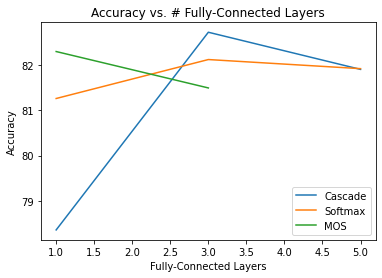

In [99]:
# ood_dsets = ['OOD', 'iNaturalist', 'SUN', 'Places', 'Textures']
display(df_ood)
models = [[('Cascade', 1), ('CascadeFC2', 2), ('CascadeFC3', 3), ('CascadeFC4', 4), ('CascadeFC5', 5)],
          [('Softmax', 1), ('SoftmaxFC3', 3), ('SoftmaxFC4', 4), ('SoftmaxFC5',5)],
         ]
accs = [
    [
        df_ood.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'), ('Accuracy', '', 'Mean')],
#         df_ood.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('Accuracy', '', 'Mean')],
        df_ood.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('Accuracy', '', 'Mean')],
#         df_ood.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('Accuracy', '', 'Mean')],
        df_ood.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('Accuracy', '', 'Mean')],
    ],
    [
        df_ood.loc[('Coarse', 'Softmax',    'CE', 'N/A'), ('Accuracy', '', 'Mean')],
#         df_ood.loc[('Coarse', 'SoftmaxFC2', 'CE', 'N/A'), ('Accuracy', '', 'Mean')],
        df_ood.loc[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('Accuracy', '', 'Mean')],
#         df_ood.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('Accuracy', '', 'Mean')],
        df_ood.loc[('Coarse', 'SoftmaxFC5', 'CE', 'N/A'), ('Accuracy', '', 'Mean')],
    ],
    [
        df_ood.loc[('Coarse', 'MOS',    'MOS', 'MOS Groups'), ('Accuracy', '', 'Mean')],
        df_ood.loc[('Coarse', 'MOSFC3', 'MOS', '2 Lvl WN'), ('Accuracy', '', 'Mean')],
    ],
]
plt.figure()
# plt.plot([1,2,3,4,5], accs[0], [1,2,3,4,5], accs[1], [1,3], accs[2])
plt.plot([1,3,5], accs[0], [1,3,5], accs[1], [1,3], accs[2])
plt.title('Accuracy vs. # Fully-Connected Layers')
plt.ylabel('Accuracy')
plt.xlabel('Fully-Connected Layers')
plt.legend(['Cascade', 'Softmax', 'MOS'])
# models 
# for info, stats in zip(exp_info, exp_stats):
#     for ods_idx, ood_dset in enumerate(ood_dsets):
#         stats_dict = {}
#         best_auroc_method = ''
#         best_auroc = -1.
#         for ood_desc in res_desc:
                
#             if stats[ood_desc][:, ods_idx, 0].mean() > best_auroc:
#                 if 'softmax' in info[1].lower():
#                     if ood_desc != 'MSP': continue
#                 best_auroc = stats[ood_desc][:, ods_idx, 0].mean()
#                 stats_dict[('Best AUROC', 'Method', ' ')] = ood_desc
#                 for met_idx, met_desc in enumerate(ood_labels):
#                     stats_dict[('Best AUROC', met_desc, 'Mean')] = stats[ood_desc][:, ods_idx, met_idx].mean()
#                     stats_dict[('Best AUROC', met_desc, 'Std')] = stats[ood_desc][:, ods_idx, met_idx].std()
#         hstr = info[3] if info[3] is not None else 'N/A'
#         for k, v in stats_dict.items():
#             df.loc[(info[0], ood_dset, info[1], info[2], hstr), k] = v
#     df.loc[(info[0], 'OOD', info[1], info[2], hstr), ('Accuracy', ' ', 'Mean')] = 100. * stats['acc'].mean()
#     df.loc[(info[0], 'OOD', info[1], info[2], hstr), ('Accuracy', ' ', 'Std')] = 100. * stats['acc'].std()
# df = df.sort_index()
# display(df)

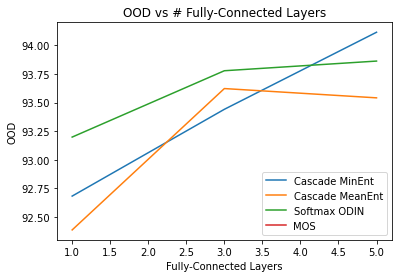

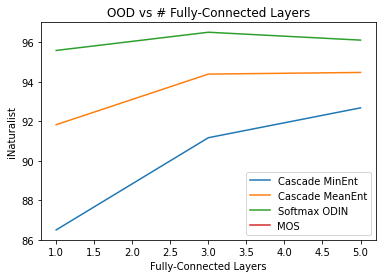

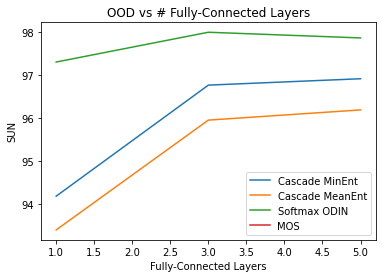

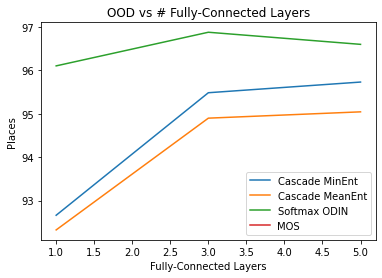

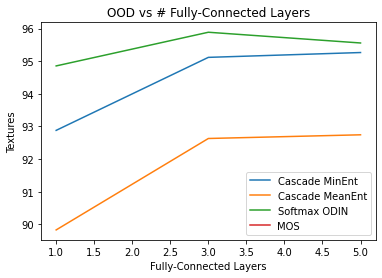

In [103]:
for ood_dsets, ood_df in zip(['OOD', 'iNaturalist', 'SUN', 'Places', 'Textures'],
                             [df_ood, df_iNaturalist, df_SUN, df_Places, df_Textures]):
    models = [[('Cascade', 1), ('CascadeFC2', 2), ('CascadeFC3', 3), ('CascadeFC4', 4), ('CascadeFC5', 5)],
              [('Softmax', 1), ('SoftmaxFC3', 3), ('SoftmaxFC4', 4), ('SoftmaxFC5',5)],
             ]
    oods = [
        [
            ood_df.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'),    ('MinEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
        ],
        [
            ood_df.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'),    ('MeanEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
        ],
        [
            ood_df.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'),    ('Pred', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
        ],
        [
            ood_df.loc[('Coarse', 'Softmax',    'CE', 'N/A'),            ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC2', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC5', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
        ],
        [
            ood_df.loc[('Coarse', 'Softmax',    'CE', 'N/A'),            ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC2', 'CE', 'N/A'), ('ODIN', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC3', 'CE', 'N/A'), ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC5', 'CE', 'N/A'), ('ODIN', 'AUROC', 'Mean')],
        ],
        [
            ood_df.loc[('Coarse', 'MOS',    'MOS', 'MOS Groups'), ('MOS', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'MOSFC3', 'MOS', '2 Lvl WN'), ('MOS', 'AUROC', 'Mean')],
        ],
    ]
    plt.figure()
#     idxsCascade = [1,2,3,4,5]
    idxsCascade = [1,3,5]
    idxsSoftmax = [1,3,5]
    idxsMOS = [1]
    plt.plot(idxsCascade, oods[0],
             idxsCascade, oods[1],
#              idxsCascade, oods[2],
#              idxsSoftmax, oods[3],
             idxsSoftmax, oods[4],
             idxsMOS, oods[5],
            )
    plt.title("OOD vs # Fully-Connected Layers")
    plt.ylabel(ood_dsets)
    plt.xlabel('Fully-Connected Layers')
    plt.legend([
        'Cascade MinEnt',
        'Cascade MeanEnt',
#         'Cascade Pred',
#         'Softmax MSP',
        'Softmax ODIN',
        'MOS',
    ])

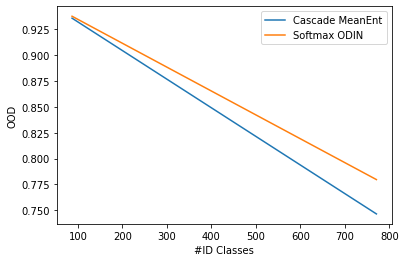

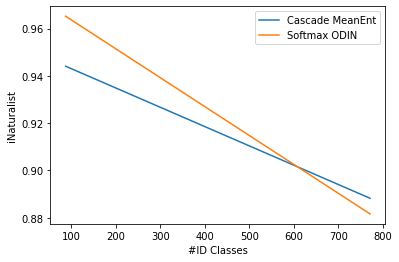

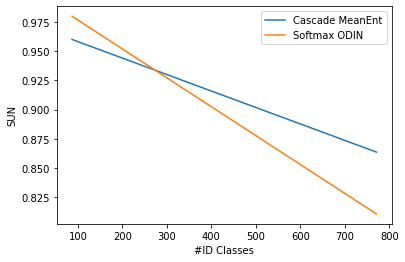

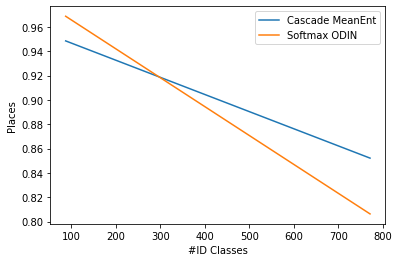

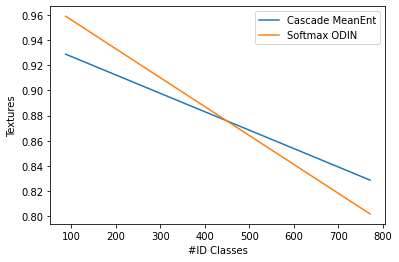

In [47]:
for ood_dsets, ood_df in zip(['OOD', 'iNaturalist', 'SUN', 'Places', 'Textures'],
                             [df_ood, df_iNaturalist, df_SUN, df_Places, df_Textures]):
    models = [[('Cascade', 1), ('CascadeFC2', 2), ('CascadeFC3', 3), ('CascadeFC4', 4), ('CascadeFC5', 5)],
              [('Softmax', 1), ('SoftmaxFC3', 3), ('SoftmaxFC4', 4), ('SoftmaxFC5',5)],
             ]
    oods = [
        [
#             ood_df.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'),    ('MinEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('MinEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'CascadeFC5', 'Soft1-1', 'Imagenet1K-WN'), ('MinEnt', 'AUROC', 'Mean')],
        ],
        [
#             ood_df.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'),    ('MeanEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('MeanEnt', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'CascadeFC5', 'Soft1-1', 'Imagenet1K-WN'), ('MeanEnt', 'AUROC', 'Mean')],
        ],
        [
#             ood_df.loc[('Coarse', 'Cascade', 'Soft1-1', 'Pruned WN'),    ('Pred', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC2', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC3', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'CascadeFC4', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'CascadeFC5', 'Soft1-1', 'Pruned WN'), ('Pred', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'CascadeFC5', 'Soft1-1', 'Imagenet1K-WN'), ('Pred', 'AUROC', 'Mean')],
        ],
        [
#             ood_df.loc[('Coarse', 'Softmax',    'CE', 'N/A'),            ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC3', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC5', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Imagenet-1K', 'SoftmaxFC5', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
        ],
        [
#             ood_df.loc[('Coarse', 'Softmax',    'CE', 'N/A'),            ('ODIN', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC3', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC5', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Imagenet-1K', 'SoftmaxFC5', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
        ],
        [
#             ood_df.loc[('Coarse', 'Softmax',    'CE', 'N/A'),            ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC3', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC5', 'Soft1-1', 'Pruned WN'), ('MSP', 'AUROC', 'Mean')],
#             ood_df.loc[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'SoftmaxFC5', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
        ],
        [
#             ood_df.loc[('Coarse', 'Softmax',    'CE', 'N/A'),            ('ODIN', 'AUROC', 'Mean')],
            ood_df.loc[('Coarse', 'SoftmaxFC3', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC4', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'SoftmaxFC5', 'Soft1-1', 'Pruned WN'), ('ODIN', 'AUROC', 'Mean')],
#             ood_df.loc[('Imagenet-1K', 'Softmax', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
            ood_df.loc[('Imagenet-1K', 'SoftmaxFC5', 'CE', 'N/A'), ('MSP', 'AUROC', 'Mean')],
        ],
#         [
#             ood_df.loc[('Coarse', 'MOS',    'MOS', '2 Lvl WN'), ('MOS', 'AUROC', 'Mean')],
#             ood_df.loc[('Coarse', 'MOSFC3', 'MOS', '2 Lvl WN'), ('MOS', 'AUROC', 'Mean')],
#         ],
    ]
    plt.figure()
    idxsCascade = [87,771]
    idxsSoftmax = [87,771]
#     idxsMOS = [1,3]
    plt.plot(
#         idxsCascade, oods[0],
        idxsCascade, oods[1],
#         idxsCascade, oods[2],
#         idxsSoftmax, oods[3],
        idxsSoftmax, oods[4],
#         idxsSoftmax, oods[5],
#         idxsSoftmax, oods[6],
#       idxsMOS, oods[5],
    )
    plt.ylabel(ood_dsets)
    plt.xlabel('#ID Classes')
    plt.legend([
#         'Cascade MinEnt',
        'Cascade MeanEnt',
#         'Cascade Pred',
#         'Softmax MSP',
        'Softmax ODIN',
#         'SoftmaxFC5 MSP',
#         'SoftmaxFC5 ODIN',
#         'MOS',
    ])